<a href="https://colab.research.google.com/github/pokhrelapar/Image-Classification/blob/main/Traffic_Sign_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recognizing Traffic Signals

#1. Install dependencies

In [6]:
!pip install opendatasets



##1.1 Download the GTSRB dataset

In [7]:
import opendatasets as od
od.download("https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aparpokhrel
Your Kaggle Key: ··········


100%|██████████| 612M/612M [00:08<00:00, 73.7MB/s]


##1.2 Import necessary libraries

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras
import cv2
import time
import warnings
import matplotlib.pyplot as plt
import os
import pathlib
import sklearn

from matplotlib import pyplot
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#2. Load datasets

In [9]:
start_time = time.time() # start the clock

root_dir = "/content/gtsrb-german-traffic-sign"

train_dir = "/content/gtsrb-german-traffic-sign/Train"

sample_train_dir = "/content/gtsrb-german-traffic-sign/train"

img_data =[]

img_labels =[]

#This is the number of classes in the dataset
num_classes = 43

h,w, channels = 32,32,3


In [10]:
categories = len(os.listdir(train_dir))

##2.1 Load the images form the correct path

In [11]:
for i in range(num_classes):
    path = train_dir + "/"+ str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, "RGB")
            resize_image = image_fromarray.resize((h, w))
            img_data.append(np.array(resize_image))
            img_labels.append(i)
        except:
            print("Error: Can't load images!")



##2.2 Convert lists into numpy arrays


In [12]:
img_data = np.array(img_data)
img_labels = np.array(img_labels)

end_time = time.time() # stop clock

print("Time taken to load the images is ", round(end_time-start_time,3),"seconds")


Time taken to load the images is  23.51 seconds


#3. Visualizing some traffic signs

##3.1 Displaying a set of images

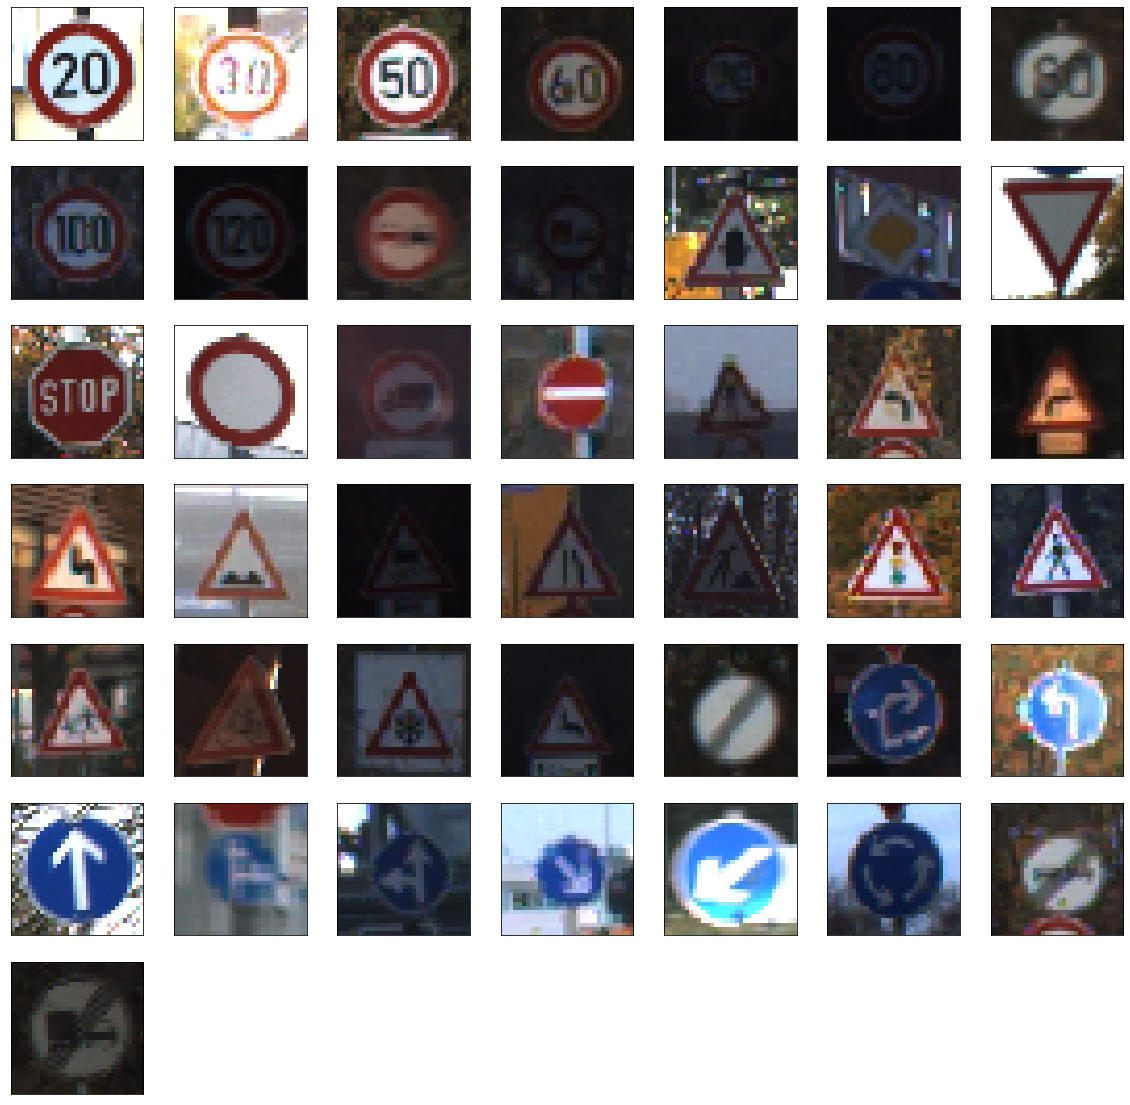

In [13]:
images_dir = pathlib.Path(train_dir)
plt.figure(figsize = (20,20))

idx = 0

for i in range(num_classes):
    plt.subplot(7,7, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    traffic_signs = list(images_dir.glob(f'{i}/*'))[0]
    images = tf.keras.utils.load_img(traffic_signs, target_size= (w,h))
    plt.imshow(images)
plt.show()

##3.2 Defining our classes

In [14]:
#Making a dictionary to map the 43 classes

classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
          }

##3.3 Visualizing classes

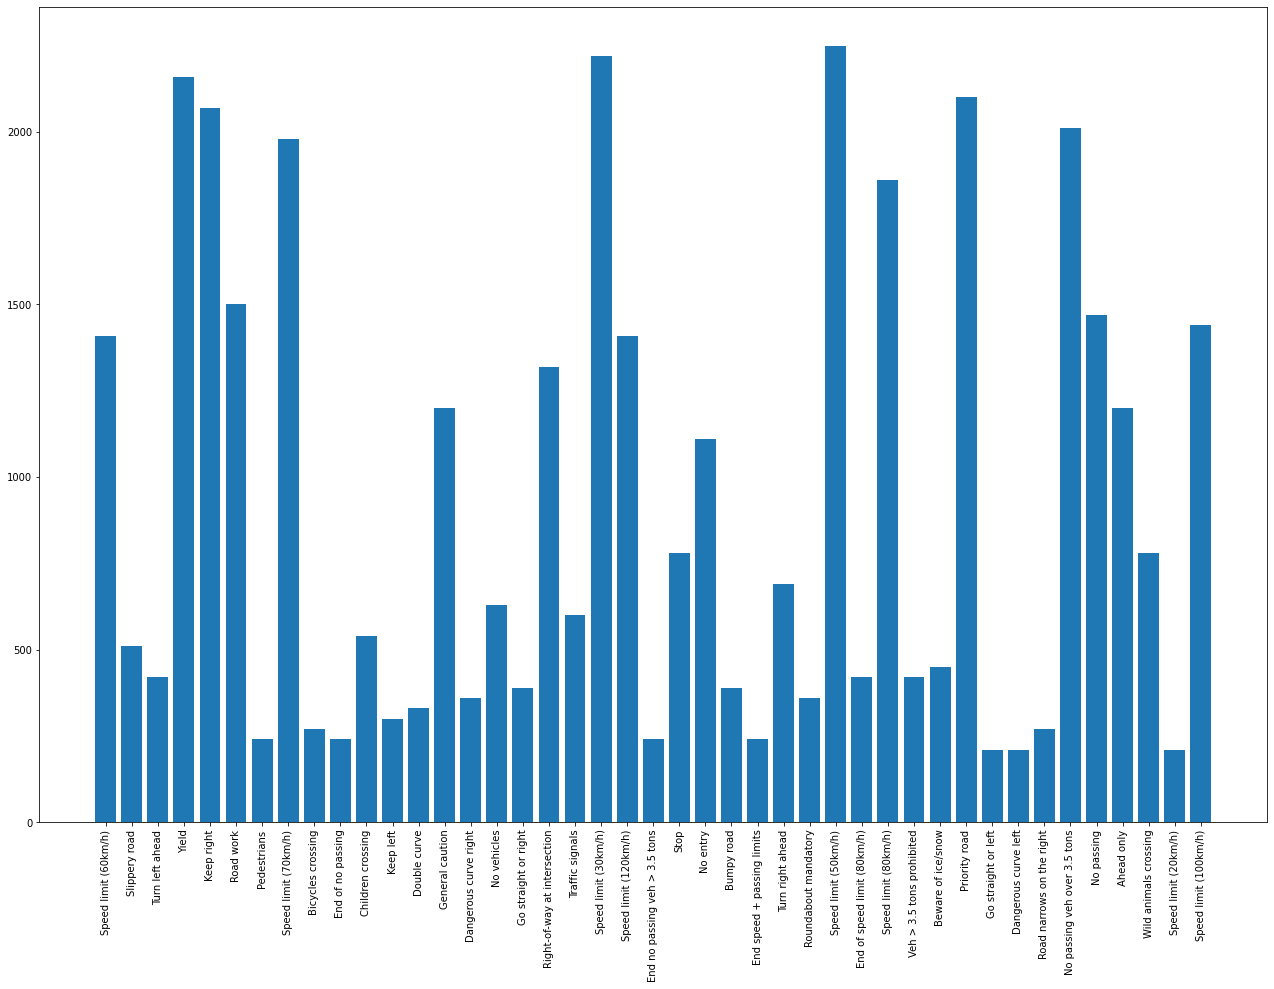

In [15]:
folders = os.listdir(train_dir)

num_train = []
num_class = []



for  folder in folders:
  t_files = os.listdir(train_dir + '/' + folder)
  num_train.append(len(t_files))
  num_class.append(classes[int(folder)])


plt.figure(figsize=(22, 15))
plt.bar(num_class, num_train)
plt.xticks(num_class, rotation='vertical')
plt.show()


#4 Data pre-processing

##4.1 Randomzing our dataset

In [16]:
random_idx = np.arange(img_data.shape[0])
np.random.shuffle(random_idx)

img_data = img_data[random_idx]
img_labels = img_labels[random_idx]

##4.2 Split and train dataset

In [17]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(img_data, img_labels, test_size=0.2, random_state=2666, shuffle=True)

          
#Normalizing x_train and x_valid within [0,1]          
x_train = x_train /255
x_valid = x_valid /255

#A look at dimensions
print("x_train.shape", x_train.shape)
print("x_valid.shape", x_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)




                                          

x_train.shape (31367, 32, 32, 3)
x_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [18]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)

print(y_train.shape)
print(y_valid.shape)


(31367, 43)
(7842, 43)


In [19]:
keras.backend.clear_session()


#5 LeNet CNN model using relu activation 

Convulution networks utilize filters to extract features form the input image. Filters alsoc called kernel are sliding windows of weights. We utilize such weights during training. Filters have small width and height and share same depth as the input.

filter depth = 1 for grayscale iamge
filter depth = 3 for rgb image

The CNN here used is a LeNet convolution neural network proposed by LeCun et. al. Normal LeNet model uses the tahn activation function, however, we used a reLu based version.

##5.1 Keras model

In [20]:
model = keras.models.Sequential([
    keras.layers.Conv2D(
    
    filters=18, kernel_size=(5,5), strides=1, activation="relu", input_shape=(h, w, channels)),
    
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    keras.layers.Conv2D(filters=36, kernel_size=(5,5), strides=1, activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    keras.layers.Conv2D(filters=36, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(1,1)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=72, activation="relu"),
    keras.layers.Dense(units=43, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 18)        1368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 36)        16236     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 36)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 36)          32436     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 36)         0

##5.2 Visualizing  model architecture

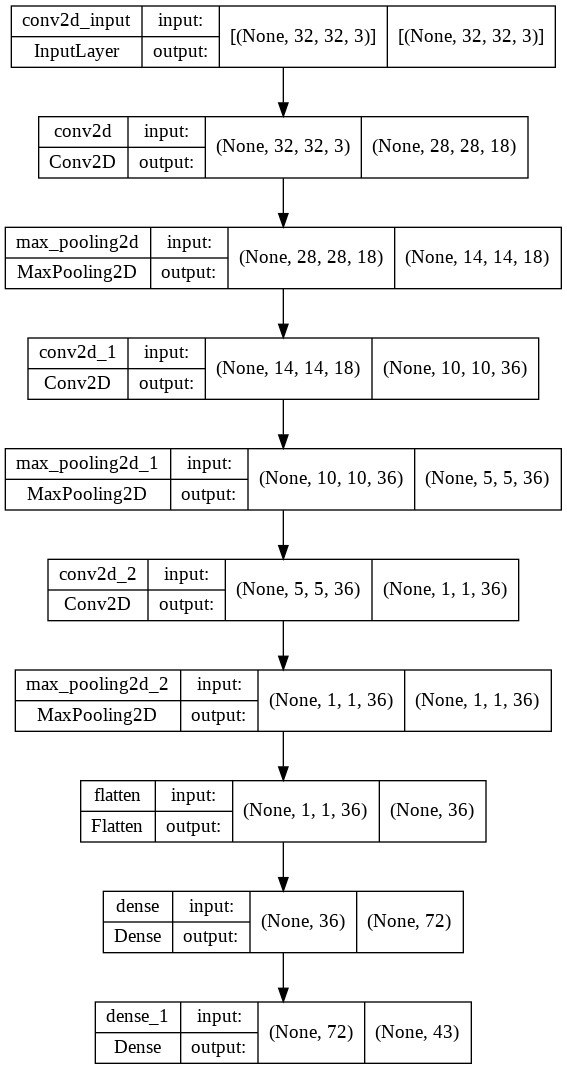

In [116]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=96)


##5.3 Compiling model with categorical_crossentropy and adam optimizer

In [39]:
# Compilation of our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

epochs = 20

history = model.fit(
    x_train, 
    y_train, 
    batch_size=32, 
    epochs=epochs, 
    validation_data=(x_valid, y_valid))

validation_data = (x_valid, y_valid)




Epoch 1/20
981/981 [==============================] - 42s 42ms/step - loss: 0.2689 - accuracy: 0.9250 - val_loss: 0.1908 - val_accuracy: 0.9508
Epoch 2/20
981/981 [==============================] - 41s 42ms/step - loss: 0.1551 - accuracy: 0.9576 - val_loss: 0.1350 - val_accuracy: 0.9657
Epoch 3/20
981/981 [==============================] - 41s 41ms/step - loss: 0.1114 - accuracy: 0.9692 - val_loss: 0.1241 - val_accuracy: 0.9685
Epoch 4/20
981/981 [==============================] - 41s 42ms/step - loss: 0.0856 - accuracy: 0.9770 - val_loss: 0.1075 - val_accuracy: 0.9711
Epoch 5/20
981/981 [==============================] - 41s 42ms/step - loss: 0.0671 - accuracy: 0.9814 - val_loss: 0.0996 - val_accuracy: 0.9750
Epoch 6/20
981/981 [==============================] - 44s 45ms/step - loss: 0.0599 - accuracy: 0.9830 - val_loss: 0.0693 - val_accuracy: 0.9825
Epoch 7/20
981/981 [==============================] - 41s 41ms/step - loss: 0.0444 - accuracy: 0.9869 - val_loss: 0.1030 - val_accuracy:

In [117]:
loss, acc = model.evaluate(x_valid, y_valid)
print('Accuracy: ', acc, '\nLoss    : ', loss)

246/246 [==============================] - 3s 13ms/step - loss: 0.0549 - accuracy: 0.9898
Accuracy:  0.9897985458374023 
Loss    :  0.05492682754993439


#6 Validation

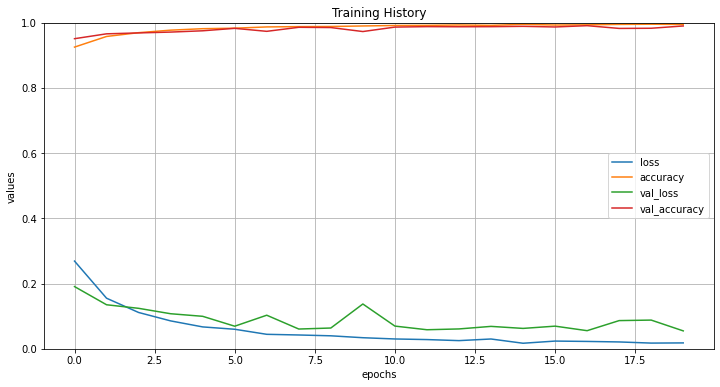

In [118]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.title('Training History')
plt.xlabel('epochs')
plt.ylabel('values')
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [21]:
test_model = pd.read_csv("/content/gtsrb-german-traffic-sign/Test.csv")

data_labels = test_model["ClassId"].values
testing_imgs = test_model["Path"].values
print(testing_imgs)

['Test/00000.png' 'Test/00001.png' 'Test/00002.png' ... 'Test/12627.png'
 'Test/12628.png' 'Test/12629.png']


#7. Prediction

##7.1 Display a random test image

(1, 32, 32, 3)
25


Text(0.5, 1.0, 'Showing random traffic sign')

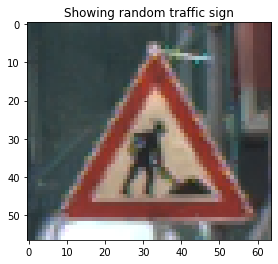

In [103]:
# The German Traffic Sign Recognition Benchmark (GTSRB) contains 43 classes
# of trafficsigns,split into 39,209 training images and 12,630 test images. 


random_idx = np.random.randint(0, 12630)

test_img = Image.open(root_dir + '/' + testing_imgs[random_idx])
img = test_img.resize((h,w))
img = np.array(img) /255.0
img = img.reshape(1, h, w, channels)

print(img.shape)
print(data_labels[random_idx])
plt.imshow(test_img)
plt.title('Showing random traffic sign')

##7.2 Predict  the random test image

In [102]:
'''
Using class_predict = model.predict_classes(img)[0] will give 

    Keras AttributeError: 'Sequential' object has no attribute 'predict_classes'

    The function has been removed from Tensorflow verson 2.6. Update code as follows:

    predict_x=model.predict(X_test)
    classes_x=np.argmax(predict_x,axis=1)

'''
#class_idx gives a numpy array , use class_idx[0] to retrive the index value belonging to the class
class_idx = np.argmax(model.predict(img), axis = 1)
print('Class: ', class_idx[0])

traffic_sign_description = classes[class_idx[0]]
print("Predicted traffic sign is: ", traffic_sign_description)

Class:  3
Predicted traffic sign is:  Speed limit (60km/h)


#8. Testing "Test dataset"

##8.1 Loading and pre-processing test data set

In [106]:
start_clock = time.time()

test_file = pd.read_csv("/content/gtsrb-german-traffic-sign/Test.csv")

test_labels = test_file["ClassId"].values

test_images = test_file["Path"].values

test_data = []


for t_imgs in test_images:
    try:
        image_test = cv2.imread(root_dir + '/'+ t_imgs)
        image_test_array = Image.fromarray(image_test, 'RGB')
        resize_test_image = image_fromarray.resize((h, w))
        test_data.append(np.array(resize_test_image))
    except:
        print("Error")
        
x_test = np.array(test_data)
x_test = x_test / 255






##8.2 Predicting test set

In [111]:
#class_idx gives a numpy array , use class_idx[0] to retrive the index value belonging to the class
class_idx = np.argmax(model.predict(x_test), axis = 1)


print('Accuray with test data')
print(accuracy_score(test_labels,class_idx))

stop_clock = time.time()

print('Time taken :', round(stop_clock-start_clock), 'seconds')


Accuray with test data
0.007125890736342043
Time taken : 548 seconds
